# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

# Summary

**I studied two investment portfolios constructed from the Amazon, Apple, Google, Tesla, and Costco stocks: The first one is volativity-oriented, i.e., the portfolio with smallest volativity. The second one is profit-oriented, i.e., assigning higher percentage to stocks with greater expected returns**

**I calculated the expectation of log yearly return and yealy volativity of these two portfolios, a direct look at yearly volativity indicates the first portfolio is safer.**

**However, I define risk based on potential loss — specifically, the likelihood and extent of losing money:**

Assuming the yearly log return follows a normal distribution with the calculated mean and standard deviation, I compute:
1. The probability of a loss: ∫_{-∞}^{0} N(x; μ, σ) dx
2. The expected loss amount: ∫_{-∞}^{0} x * N(x; μ, σ) dx
to understand which portfolio is more risky. The conclusion is actually the second portfolio is safer, opposite to the intuitive results by looking at volativity only.

**I also calculate the Sharpe Ratio which is defined as the ratio between the expectation of log yearly return and the yearly volativity, which also shows the second portfolio is safer.**



In [180]:
#Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
import datetime as dt
sns.set_style('darkgrid')

import yfinance as yf

In [306]:
#  I will choose the following five stocks to construct my investment portfolios

tickers = ['AMZN', 'AAPL', 'GOOG', 'TSLA', 'COST']

start_date = dt.datetime.today()-dt.timedelta(days = 2*365)
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end = end_date)

[*********************100%***********************]  5 of 5 completed


In [270]:
stock.head()

Price            Close                                                  \
Ticker            AAPL        AMZN        COST        GOOG        TSLA   
Date                                                                     
2023-06-09  179.166153  123.430000  499.769867  122.290779  244.399994   
2023-06-12  181.968079  126.570000  503.335022  123.763794  249.830002   
2023-06-13  181.492828  126.660004  504.349426  123.843422  258.709991   
2023-06-14  182.126511  126.419998  509.354034  123.793655  256.790009   
2023-06-15  184.166077  127.110001  511.267151  125.197014  255.899994   

Price             High                                                  ...  \
Ticker            AAPL        AMZN        COST        GOOG        TSLA  ...   
Date                                                                    ...   
2023-06-09  180.423553  125.800003  504.388031  123.699110  252.419998  ...   
2023-06-12  182.067093  126.779999  503.624914  124.161910  250.970001  ...   
2023-06-13  182.324498  128.410004  505.247938  125.266681  259.679993  ...   
2023-06-14  182.562151  126.949997  509.981996  124.201726  261.570007  ...   
2023-06-15  184.671031  127.690002  513.276759  125.565272  258.950012  ...   

Price             Open                                                  \
Ticker            AAPL        AMZN        COST        GOOG        TSLA   
Date                                                                     
2023-06-09  179.700793  124.080002  500.649037  121.982235  249.070007   
2023-06-12  179.473070  124.019997  499.769986  122.813294  247.940002   
2023-06-13  180.987889  128.119995  504.349426  125.057672  253.509995   
2023-06-14  181.552258  126.699997  507.228494  123.216395  260.170013   
2023-06-15  182.136410  125.209999  511.093251  123.296014  248.399994   

Price         Volume                                          
Ticker          AAPL      AMZN     COST      GOOG       TSLA  
Date                                                          
2023-06-09  48870700  51330000  1287300  20304500  199882300  
2023-06-12  54274900  51338000  1404500  22255700  150337900  
2023-06-13  54929100  50564800  1204700  19287700  162384300  
2023-06-14  57462900  52422500  1841400  24659600  170575500  
2023-06-15  65433200  60458500  1871600  24517100  160171200  

[5 rows x 25 columns]

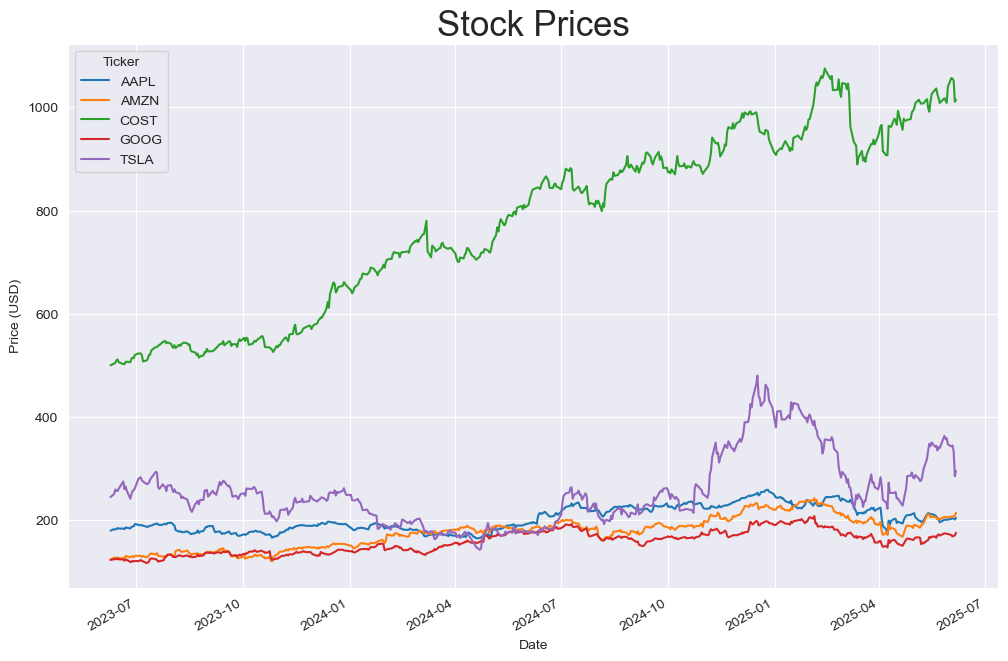

In [308]:
# plot the strock prices
stock['Close'].plot(figsize = (12,8))
plt.title(f'Stock Prices', size = 25)
plt.ylabel('Price (USD)')
plt.show()

Text(0.5, 1.0, 'Logs of Daily Returns')

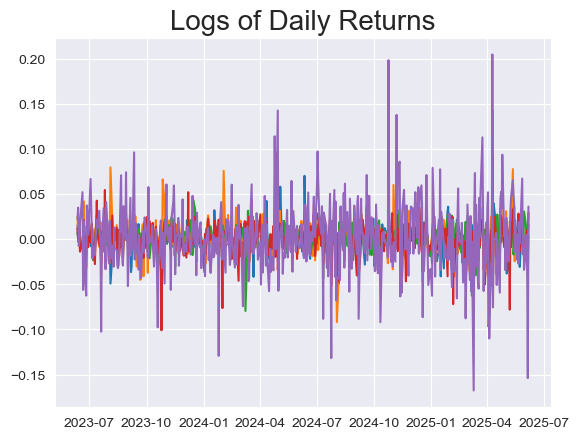

In [310]:
# calculate and plot the log daily returns

daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

plt.plot(daily_returns)
plt.title(f'Logs of Daily Returns', size = 20)

In [312]:
#calculate the means and covariance matrix 

covariance_matrix = 252*((daily_returns).cov())
mean=daily_returns.mean()

In [314]:
mean

Ticker
AAPL    0.000259
AMZN    0.001099
COST    0.001420
GOOG    0.000717
TSLA    0.000378
dtype: float64

In [316]:
covariance_matrix

Ticker,AAPL,AMZN,COST,GOOG,TSLA
Ticker,,,,,
AAPL,0.074686,0.042443,0.020453,0.037976,0.078859
AMZN,0.042443,0.098122,0.023318,0.056508,0.089113
COST,0.020453,0.023318,0.041626,0.016020,0.045855
GOOG,0.037976,0.056508,0.016020,0.088421,0.077154
TSLA,0.078859,0.089113,0.045855,0.077154,0.397192


In [318]:
# Design two investment portfolios
# Since the mean of the log daily returns for all five stocks is positive, 
# I can conclude that any portfolio constructed from these stocks have a positive expectation of the log daily return, i.e., it is likely to be profitable.

# For the first portfolio, I aim to minimize volatility and select the one with the lowest standard deviation.


# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Sum of weights equals 1 
#Weight is a number in [0,1]
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-0},
              {'type': 'ineq', 'fun': lambda weights: 1-max(weights)})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

mu1=252*np.dot(optimal_weights,mean)
sig1=result.fun

# Mean yearly log return
print(f'The expected yearly log return is {mu1}')

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(np.sort(tickers), optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

print(f'The yearly volativity is {sig1}')

The expected yearly log return is 0.2746731136343039
Optimal Asset Weights to minimize volatility:
AAPL: Weight = 0.1730
AMZN: Weight = 0.0086
COST: Weight = 0.6387
GOOG: Weight = 0.1797
TSLA: Weight = 0.0000
The yearly volativity is 0.1821929647830649


In [331]:
optimal_weights

array([-2.34780373e-17,  1.43498766e-01,  7.13002468e-01,  1.33498766e-01,
        1.00000000e-02])

In [254]:
np.sort(tickers)

array(['AAPL', 'AMZN', 'COST', 'GOOG', 'TSLA'], dtype='<U4')

In [325]:
# For the second investment portfolio, I adopt a profit-oriented strategy by allocating higher weights to stocks with greater expected returns.

initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Always assign more percentages to stocks with higher expected return
#Weight is a number in [0,1]
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-0},
              {'type': 'ineq', 'fun': lambda weights: 1-max(weights)},
              {'type': 'ineq', 'fun': lambda weights: weights[2]-weights[1]-0.01},
               {'type': 'ineq', 'fun': lambda weights: weights[1]-weights[3]-0.01},
               {'type': 'ineq', 'fun': lambda weights: weights[3]-weights[4]-0.01},
              {'type': 'ineq', 'fun': lambda weights: weights[4]-weights[0]-0.01})

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

if result.success:
    print("Optimization successful.")
else:
    print("Optimization failed:", result.message)

# Optimal asset weights
optimal_weights = result.x

mu2=252*np.dot(optimal_weights,mean)
sig2=result.fun

# Mean yearly log return
print(f'The expected yearly log return is {mu2}')

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(np.sort(tickers), optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

print(f'The yearly volativity is {sig2}')


Optimization successful.
The expected yearly log return is 0.3199064527446702
Optimal Asset Weights to minimize volatility:
AAPL: Weight = -0.0000
AMZN: Weight = 0.1435
COST: Weight = 0.7130
GOOG: Weight = 0.1335
TSLA: Weight = 0.0100
The yearly volativity is 0.18947179528542996


In [327]:
# As we can see, the second portfolio offers higher expected profit but also exhibits a little bit greater volatility, indicating increased risk.
# However, I define risk based on potential loss — specifically, the likelihood and extent of losing money.
# Assuming the yearly log return follows a normal distribution with the calculated mean and standard deviation, I compute:
# 1. The probability of a loss: ∫_{-∞}^{0} f(x; μ, σ) dx
# 2. The expected loss amount: ∫_{-∞}^{0} x * f(x; μ, σ) dx


print(f'The probability to lose money for portfolio 1 is {norm.cdf(0, loc=mu1, scale=sig1)}; The expected money lose rate is {mu1 * norm.cdf(-mu1/sig1) - sig1 * norm.pdf(-mu1/sig1)}')
print(f'The probability to lose money for portfolio 2 is {norm.cdf(0, loc=mu2, scale=sig2)}; The expected money lose rate is {mu2 * norm.cdf(-mu2/sig2) - sig2 * norm.pdf(-mu2/sig2)}')

The probability to lose money for portfolio 1 is 0.06582916923618709; The expected money lose rate is -0.005247730683217242
The probability to lose money for portfolio 2 is 0.04566608430377421; The expected money lose rate is -0.0035640727379588153


In [329]:
# We observe that the second portfolio has a lower probability of losing money and a smaller expected loss.
# According to this definition, the second portfolio is actually safer than the first.
# I also compare the Sharpe Ratio: mu/sig for two portfolios 
print(f'The Sharpe Ratio of portfolio 1 is {mu1/sig1}')
print(f'The Sharpe Ratio of portfolio 2 is {mu2/sig2}')


The Sharpe Ratio of portfolio 1 is 1.5075945109151392
The Sharpe Ratio of portfolio 2 is 1.688411999594699


In [ ]:
# The Sharpe Ratio of the second portfolio is higher, also suggesting that the second portfolio is safer.